TensorFlow version: 2.18.0
Preparando dataset Blender sintético...
Intentando descargar dataset NeRF para 'lego'...
Descargando tiny_nerf_data como alternativa...
Error con tiny_nerf: HTTP Error 404: Not Found
Intentando descargar escena individual...
Descargando desde: https://github.com/bmild/nerf/raw/master/data/nerf_example_data.zip
Error: HTTP Error 404: Not Found
Descargando desde: https://www.robots.ox.ac.uk/~vgg/data/nerf/nerf_example_data.zip
Error: HTTP Error 404: Not Found
No se pudo descargar el dataset real. Creando dataset sintético para 'lego'...
Creando dataset sintético simple para 'lego'...
✅ Dataset sintético creado exitosamente!


/tmp/ipython-input-4-3356395988.py:351: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(fname))


Dimensiones de la imagen: H=32, W=32, focal=25.0
Dataset cargado: entrenamiento (40, 32, 32, 3), prueba (5, 32, 32, 3)


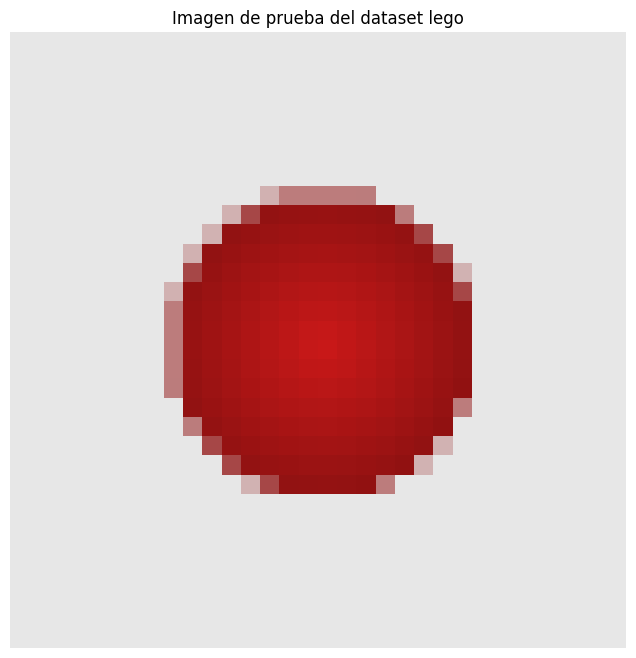

🚀 Iniciando entrenamiento rápido con dataset Blender...
⚡ Iter: 0, Time per 50 iters: 3.30s, Loss: 0.3377


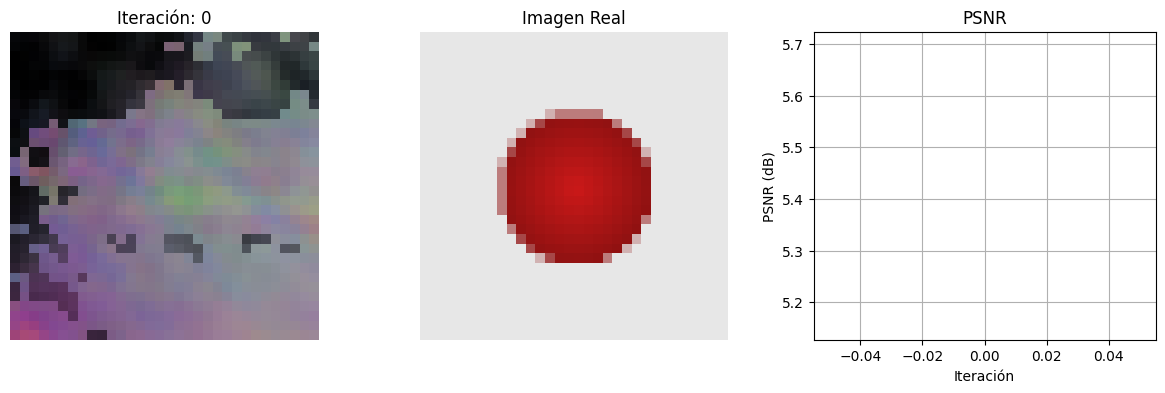

⚡ Iter: 50, Time per 50 iters: 5.01s, Loss: 0.0641


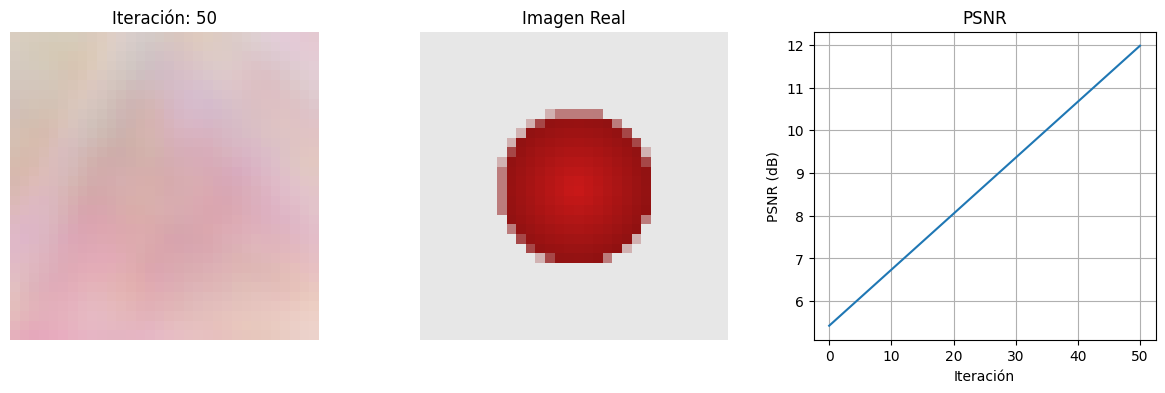

⚡ Iter: 100, Time per 50 iters: 5.55s, Loss: 0.0283


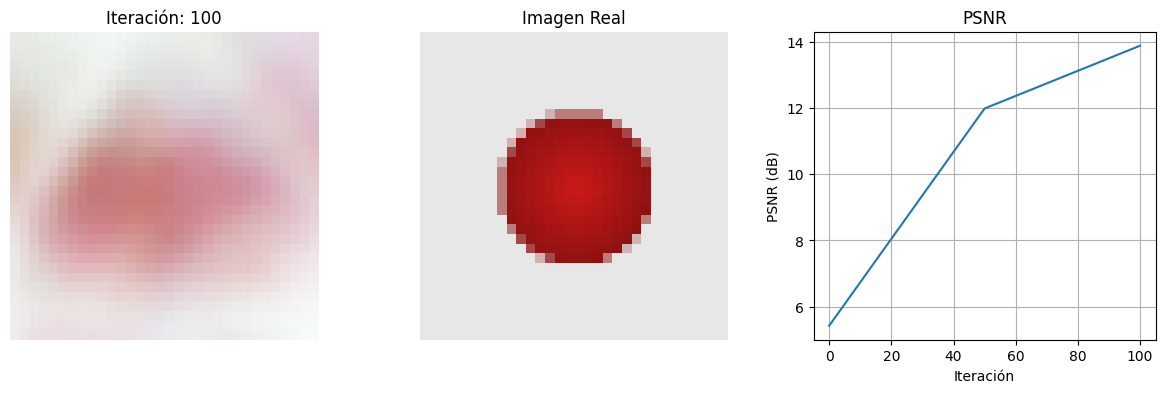

⚡ Iter: 150, Time per 50 iters: 4.90s, Loss: 0.0098


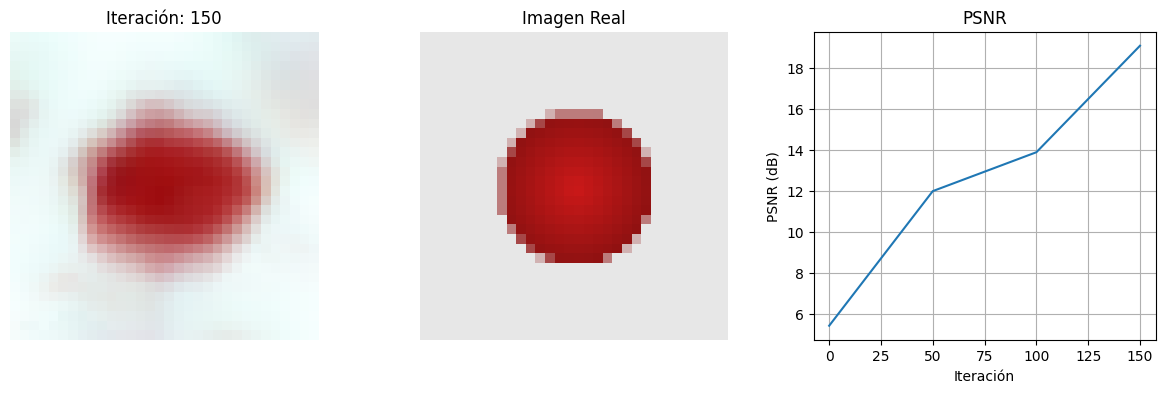

⚡ Iter: 200, Time per 50 iters: 4.97s, Loss: 0.0057


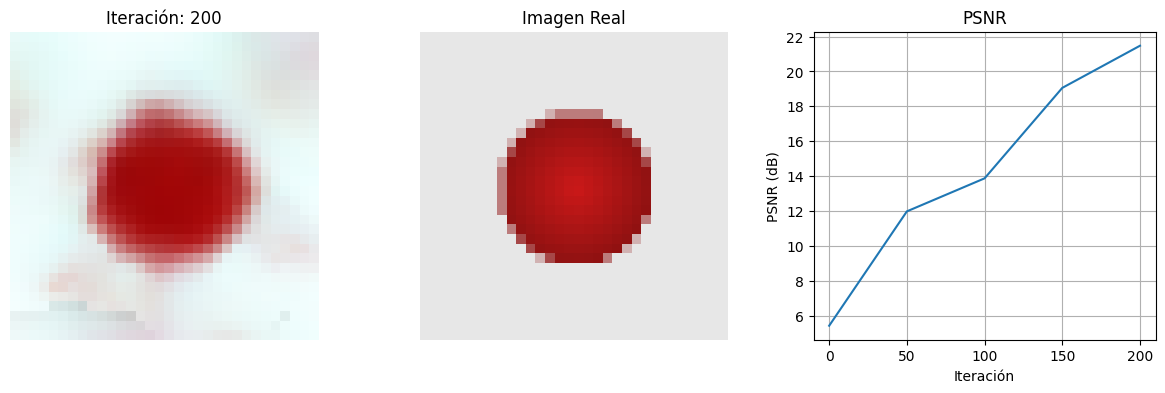

⚡ Iter: 250, Time per 50 iters: 5.44s, Loss: 0.0041


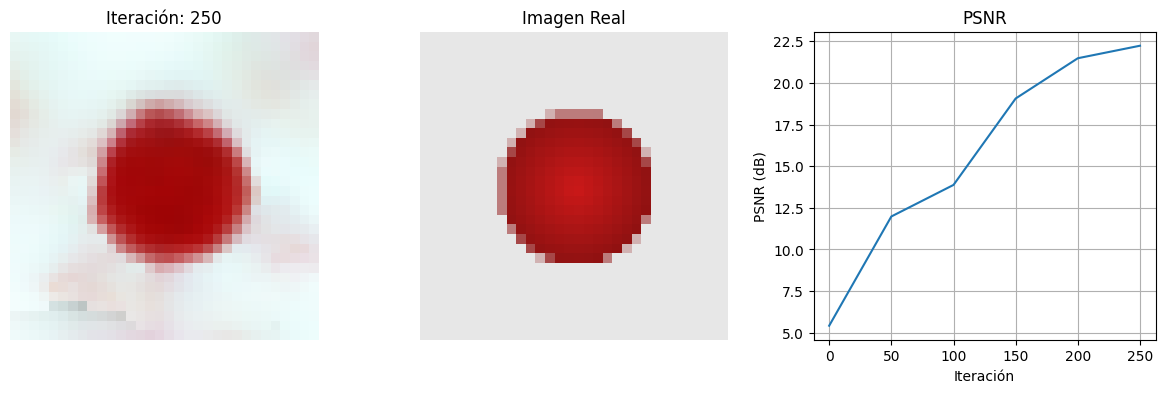

⚡ Iter: 300, Time per 50 iters: 4.88s, Loss: 0.0032


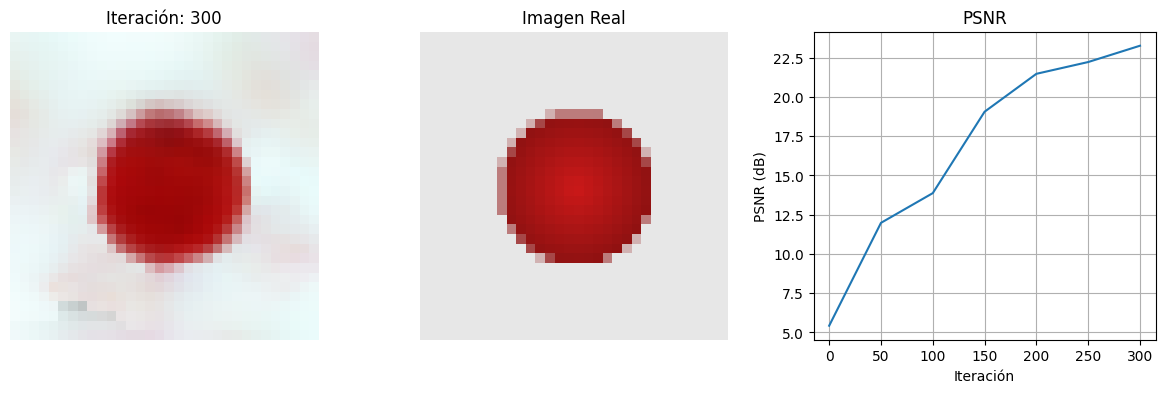

⚡ Iter: 350, Time per 50 iters: 5.51s, Loss: 0.0027


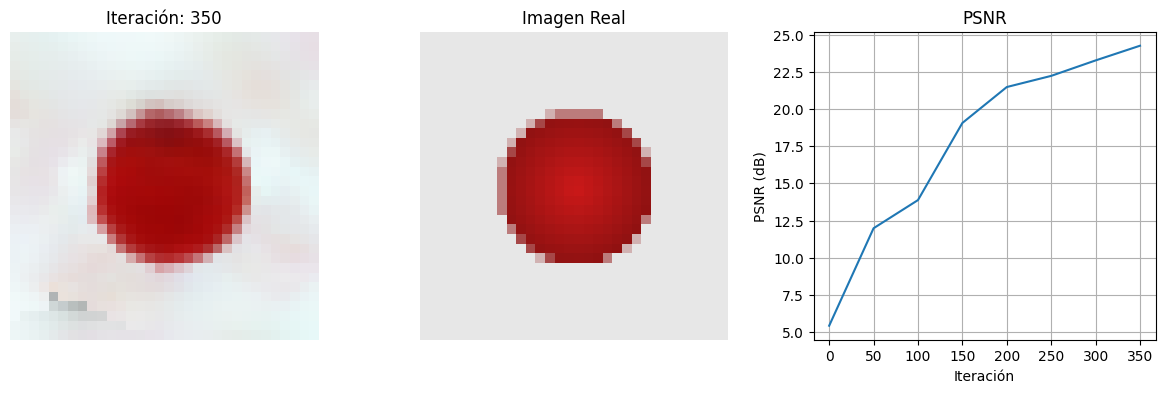

⚡ Iter: 400, Time per 50 iters: 4.94s, Loss: 0.0021


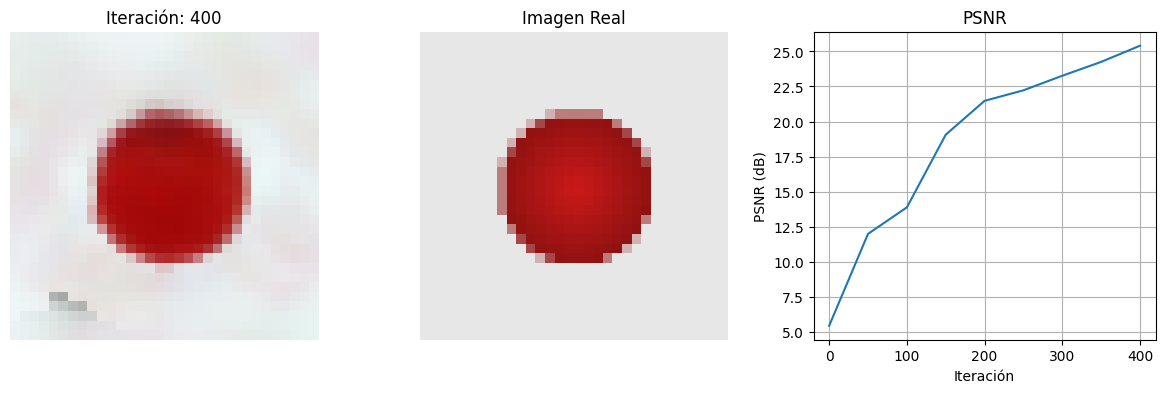

⚡ Iter: 450, Time per 50 iters: 5.47s, Loss: 0.0012


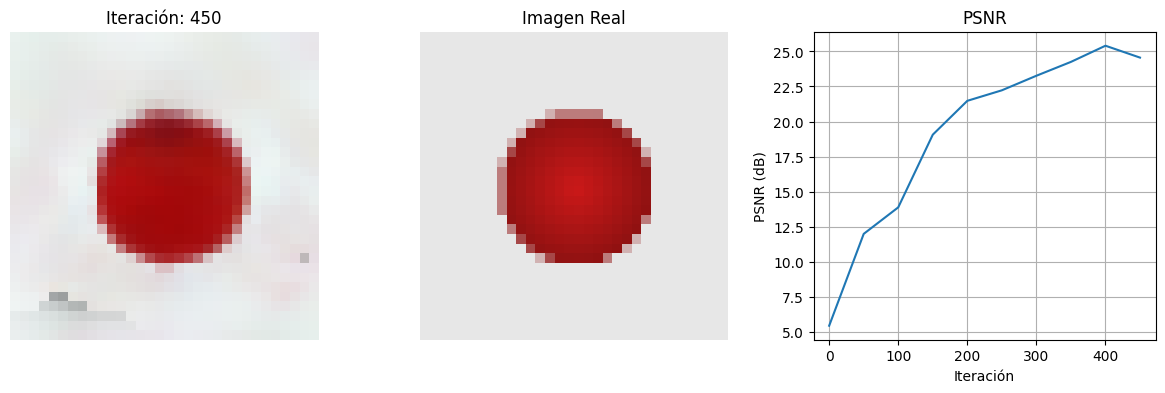

⚡ Iter: 500, Time per 50 iters: 4.85s, Loss: 0.0010


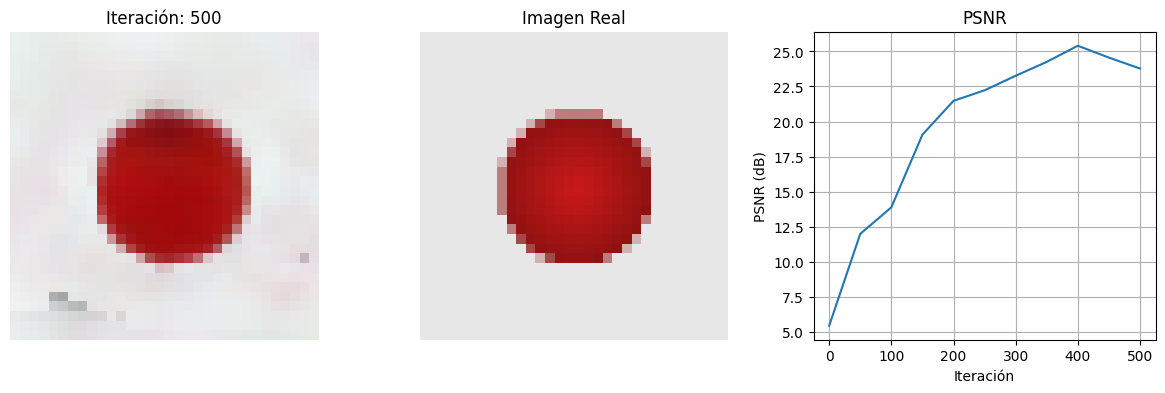

🎉 Entrenamiento completado!

📸 Renderizando vistas adicionales...
Renderizando vista 1/2...
Renderizando vista 2/2...


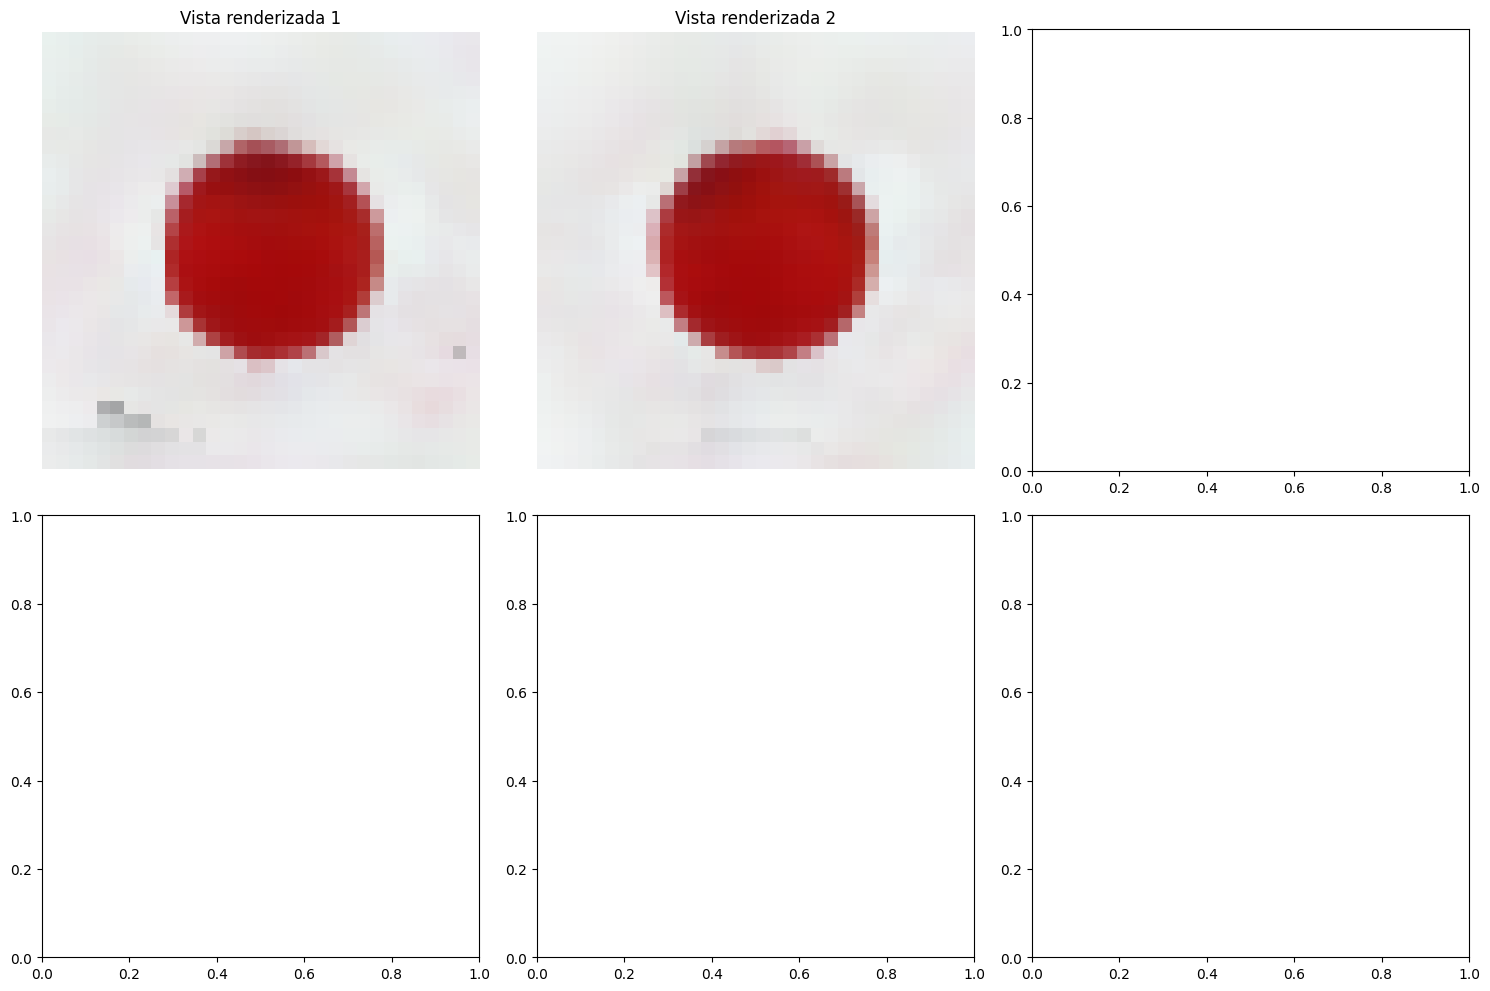


🎬 Creando video...

✅ ¡Proceso completado exitosamente!


In [4]:
# Intenta importar google.colab para verificar si se está ejecutando en Colab

try:

    import google.colab

    IN_COLAB = True

except ImportError:

    IN_COLAB = False


import os

import sys

import tensorflow as tf

import numpy as np

import imageio

import json

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from IPython.display import HTML

from base64 import b64encode

import urllib.request

import zipfile


# Imprime la versión de TensorFlow para verificar que sea >= 2.0

print("TensorFlow version:", tf.__version__)


# ####################################################################

# NUEVO: Dataset Blender sintético de NeRF

# ####################################################################


def download_blender_data(scene='lego'):

    """

    Descarga el dataset sintético de Blender para NeRF.

    Opciones: 'chair', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic', 'ship'

    """

    # Crear directorio si no existe

    if not os.path.exists('data'):

        os.makedirs('data')



    # Verificar si ya existe

    if os.path.exists(f'data/nerf_synthetic/{scene}'):

        print(f"Dataset {scene} ya existe!")

        return



    print(f"Intentando descargar dataset NeRF para '{scene}'...")



    # Opción 1: Usar un dataset más pequeño de ejemplo

    if scene == 'lego':

        # Usar el dataset tiny_nerf_data que es más pequeño y confiable

        tiny_nerf_url = "https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz"



        try:

            print("Descargando tiny_nerf_data como alternativa...")

            os.makedirs('data/tiny_nerf', exist_ok=True)

            urllib.request.urlretrieve(tiny_nerf_url, 'data/tiny_nerf/tiny_nerf_data.npz')



            # Convertir el formato tiny_nerf a formato Blender

            print("Convirtiendo formato tiny_nerf a formato Blender...")

            data = np.load('data/tiny_nerf/tiny_nerf_data.npz')

            images = data['images']  # (106, 100, 100, 3)

            poses = data['poses']    # (106, 4, 4)

            focal = data['focal']    # float



            # Crear estructura de directorios

            os.makedirs(f'data/nerf_synthetic/{scene}', exist_ok=True)



            # Dividir en train/val/test

            n_images = images.shape[0]

            n_train = int(n_images * 0.8)

            n_val = int(n_images * 0.1)



            # Guardar imágenes y crear JSONs

            H, W = images.shape[1:3]

            camera_angle_x = 2 * np.arctan(W / (2 * focal))



            # Función auxiliar para crear datos de transformación

            def create_transform_data(indices, split_name):

                frames = []

                for i, idx in enumerate(indices):

                    # Guardar imagen

                    img_path = f'data/nerf_synthetic/{scene}/{split_name}_{i}.png'

                    img = (images[idx] * 255).astype(np.uint8)

                    # Añadir canal alpha

                    img_rgba = np.ones((H, W, 4), dtype=np.uint8) * 255

                    img_rgba[:, :, :3] = img

                    imageio.imwrite(img_path, img_rgba)



                    # Añadir frame

                    frames.append({

                        "file_path": f"./{split_name}_{i}",

                        "transform_matrix": poses[idx].tolist()

                    })



                return {

                    "camera_angle_x": float(camera_angle_x),

                    "frames": frames

                }



            # Crear splits

            train_data = create_transform_data(range(n_train), 'train')

            val_data = create_transform_data(range(n_train, n_train + n_val), 'val')

            test_data = create_transform_data(range(n_train + n_val, n_images), 'test')



            # Guardar JSONs

            with open(f'data/nerf_synthetic/{scene}/transforms_train.json', 'w') as f:

                json.dump(train_data, f, indent=2)

            with open(f'data/nerf_synthetic/{scene}/transforms_val.json', 'w') as f:

                json.dump(val_data, f, indent=2)

            with open(f'data/nerf_synthetic/{scene}/transforms_test.json', 'w') as f:

                json.dump(test_data, f, indent=2)



            print("✅ Dataset tiny_nerf convertido exitosamente!")

            return



        except Exception as e:

            print(f"Error con tiny_nerf: {e}")



    # Opción 2: Intentar descargar solo la escena específica

    print("Intentando descargar escena individual...")

    scene_urls = {

        'lego': [

            "https://github.com/bmild/nerf/raw/master/data/nerf_example_data.zip",

            "https://www.robots.ox.ac.uk/~vgg/data/nerf/nerf_example_data.zip"

        ]

    }



    if scene in scene_urls:

        for url in scene_urls[scene]:

            try:

                print(f"Descargando desde: {url}")

                urllib.request.urlretrieve(url, f'data/{scene}_data.zip')



                # Extraer

                with zipfile.ZipFile(f'data/{scene}_data.zip', 'r') as zip_ref:

                    zip_ref.extractall('data/')



                # Reorganizar archivos si es necesario

                if os.path.exists(f'data/nerf_example_data'):

                    os.rename('data/nerf_example_data', f'data/nerf_synthetic/{scene}')



                # Limpiar

                if os.path.exists(f'data/{scene}_data.zip'):

                    os.remove(f'data/{scene}_data.zip')



                print(f"✅ Dataset {scene} descargado!")

                return



            except Exception as e:

                print(f"Error: {e}")

                continue



    # Si todo falla, crear dataset sintético

    print(f"No se pudo descargar el dataset real. Creando dataset sintético para '{scene}'...")

    create_simple_synthetic_dataset(scene, size=64, num_images=50)


def load_blender_data(basedir, half_res=False, testskip=1):

    """

    Carga el dataset sintético de Blender para NeRF.

    """

    splits = ['train', 'val', 'test']

    metas = {}

    for s in splits:

        with open(os.path.join(basedir, f'transforms_{s}.json'), 'r') as fp:

            metas[s] = json.load(fp)


    all_imgs = []

    all_poses = []

    counts = [0]



    for s in splits:

        meta = metas[s]

        imgs = []

        poses = []



        if s == 'train' or testskip == 0:

            skip = 1

        else:

            skip = testskip



        for frame in meta['frames'][::skip]:

            fname = os.path.join(basedir, frame['file_path'] + '.png')

            imgs.append(imageio.imread(fname))

            poses.append(np.array(frame['transform_matrix']))



        imgs = (np.array(imgs) / 255.).astype(np.float32)  # Normalizar a [0,1]

        poses = np.array(poses).astype(np.float32)

        counts.append(counts[-1] + imgs.shape[0])

        all_imgs.append(imgs)

        all_poses.append(poses)



    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)]



    imgs = np.concatenate(all_imgs, 0)

    poses = np.concatenate(all_poses, 0)



    H, W = imgs[0].shape[:2]

    camera_angle_x = float(meta['camera_angle_x'])

    focal = .5 * W / np.tan(.5 * camera_angle_x)



    # Aplicar fondo blanco a imágenes RGBA

    if imgs.shape[-1] == 4:

        imgs = imgs[...,:3]*imgs[...,-1:] + (1.-imgs[...,-1:])



    if half_res:

        H = H//2

        W = W//2

        focal = focal/2.



        imgs_half_res = np.zeros((imgs.shape[0], H, W, 3))

        for i, img in enumerate(imgs):

            imgs_half_res[i] = tf.image.resize(img, [H, W], method='area').numpy()

        imgs = imgs_half_res



    return imgs, poses, [H, W, focal], i_split


# Función alternativa para crear dataset sintético simple
def create_simple_synthetic_dataset(scene='lego', size=64, num_images=50):
    """
    Crea un dataset sintético simple si no se puede descargar el real.
    """
    print(f"Creando dataset sintético simple para '{scene}'...")

    # Crear estructura de directorios
    basedir = f'data/nerf_synthetic/{scene}'
    os.makedirs(basedir, exist_ok=True)

    # Parámetros de la cámara
    focal_length = 50.0
    camera_angle_x = 2 * np.arctan(size / (2 * focal_length))

    # Generar imágenes y poses
    all_images = []
    all_poses = []

    for i in range(num_images):
        # Posición de la cámara en una esfera
        theta = 2 * np.pi * i / num_images
        phi = np.pi / 4  # 45 grados de elevación
        radius = 4.0

        # Posición de la cámara
        cam_pos = np.array([
            radius * np.cos(theta) * np.sin(phi),
            radius * np.sin(theta) * np.sin(phi),
            radius * np.cos(phi)
        ])

        # Matriz de pose (cámara mirando al origen)
        forward = -cam_pos / np.linalg.norm(cam_pos)
        up = np.array([0., 0., 1.])
        right = np.cross(forward, up)
        right = right / np.linalg.norm(right)
        up = np.cross(right, forward)

        pose = np.eye(4)
        pose[:3, 0] = right
        pose[:3, 1] = -up  # OpenGL convention
        pose[:3, 2] = -forward  # OpenGL convention
        pose[:3, 3] = cam_pos
        all_poses.append(pose.tolist())

        # Crear imagen sintética simple
        img = np.ones((size, size, 4)) * 0.9  # Fondo gris claro

        # Dibujar un objeto simple en el centro
        center = size // 2
        radius_obj = size // 4

        for y in range(size):
            for x in range(size):
                dx = x - center
                dy = y - center
                dist = np.sqrt(dx**2 + dy**2)

                if dist < radius_obj:
                    # Color del objeto basado en la posición
                    if scene == 'lego':
                        # Lego rojo
                        img[y, x] = [0.8, 0.1, 0.1, 1.0]
                    elif scene == 'chair':
                        # Silla marrón
                        img[y, x] = [0.6, 0.4, 0.2, 1.0]
                    else:
                        # Color genérico
                        img[y, x] = [0.2, 0.4, 0.8, 1.0]

                    # Añadir algo de shading
                    shade = 1.0 - (dist / radius_obj) * 0.3
                    img[y, x, :3] *= shade

        # Guardar imagen
        img_path = os.path.join(basedir, f'r_{i}.png')
        imageio.imwrite(img_path, (img * 255).astype(np.uint8))
        all_images.append(f'./r_{i}')

    # Crear archivos JSON de transformaciones
    n_train = int(num_images * 0.8)
    n_val = int(num_images * 0.1)

    # Train split
    train_data = {
        "camera_angle_x": camera_angle_x,
        "frames": [{"file_path": all_images[i], "transform_matrix": all_poses[i]}
                   for i in range(n_train)]
    }

    # Val split
    val_data = {
        "camera_angle_x": camera_angle_x,
        "frames": [{"file_path": all_images[i], "transform_matrix": all_poses[i]}
                   for i in range(n_train, n_train + n_val)]
    }

    # Test split
    test_data = {
        "camera_angle_x": camera_angle_x,
        "frames": [{"file_path": all_images[i], "transform_matrix": all_poses[i]}
                   for i in range(n_train + n_val, num_images)]
    }

    # Guardar JSONs
    with open(os.path.join(basedir, 'transforms_train.json'), 'w') as f:
        json.dump(train_data, f, indent=2)
    with open(os.path.join(basedir, 'transforms_val.json'), 'w') as f:
        json.dump(val_data, f, indent=2)
    with open(os.path.join(basedir, 'transforms_test.json'), 'w') as f:
        json.dump(test_data, f, indent=2)

    print("✅ Dataset sintético creado exitosamente!")

# Descargar y cargar dataset
print("Preparando dataset Blender sintético...")
scene = 'lego'  # Puedes cambiar a: 'chair', 'drums', 'ficus', 'hotdog', 'materials', 'mic', 'ship'

# Intentar descargar el dataset real, si falla usar el sintético
try:
    download_blender_data(scene)
except Exception as e:
    print(f"\n⚠️ No se pudo descargar el dataset real: {e}")
    print("Creando dataset sintético alternativo...")
    create_simple_synthetic_dataset(scene, size=64, num_images=50)

# Cargar datos
basedir = f'data/nerf_synthetic/{scene}'
images, poses, hwf, i_split = load_blender_data(basedir, half_res=True)

# Extraer dimensiones

H, W, focal = hwf

H, W = int(H), int(W)

print(f"Dimensiones de la imagen: H={H}, W={W}, focal={focal}")

# Separar datos de entrenamiento, validación y prueba

i_train, i_val, i_test = i_split

train_imgs = images[i_train]

train_poses = poses[i_train]

test_imgs = images[i_test]

test_poses = poses[i_test]


print(f"Dataset cargado: entrenamiento {train_imgs.shape}, prueba {test_imgs.shape}")

# Seleccionar imagen de prueba

testimg_idx = 0

testimg = test_imgs[testimg_idx]

testpose = test_poses[testimg_idx]


# Visualizar una imagen de prueba

plt.figure(figsize=(8, 8))

plt.imshow(testimg)

plt.title(f"Imagen de prueba del dataset {scene}")

plt.axis('off')

plt.show()


"""

## Definir el modelo y las funciones de renderizado de NeRF (OPTIMIZADO)

"""


def posenc(x):

    """Codificación posicional simplificada para las entradas."""

    rets = [x]

    L_embed = 4  # ✅ Reducido de 6 a 4 para mayor velocidad

    for i in range(L_embed):

        for fn in [tf.sin, tf.cos]:

            rets.append(fn(tf.cast(2.**i, tf.float32) * x))  # ✅ CAST explícito

    return tf.concat(rets, -1)


embed_fn = posenc


def init_model(D=4, W=128):  # ✅ Modelo MÁS PEQUEÑO: 4 capas, 128 neuronas

    """Inicializa el modelo de Keras optimizado para velocidad."""

    relu = tf.keras.layers.ReLU()

    dense = lambda W=W, act=relu: tf.keras.layers.Dense(W, activation=act, dtype='float32')  # ✅ DTYPE explícito



    # 3 + 3*2*4 = 27 (reducido desde 39)

    inputs = tf.keras.Input(shape=(27,), dtype='float32')  # ✅ DTYPE explícito


    outputs = inputs

    for i in range(D):

        outputs = dense()(outputs)

        if i % 2 == 0 and i > 0:  # ✅ Skip connections cada 2 capas en lugar de 4

            outputs = tf.keras.layers.Concatenate(axis=-1)([outputs, inputs])



    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


def get_rays(H, W, focal, c2w):

    """Genera rayos desde la cámara al mundo."""

    # ✅ Asegurar que todo sea float32

    H, W = tf.cast(H, tf.float32), tf.cast(W, tf.float32)

    focal = tf.cast(focal, tf.float32)

    c2w = tf.cast(c2w, tf.float32)



    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')

    dirs = tf.stack([(i - W*0.5)/focal, -(j - H*0.5)/focal, -tf.ones_like(i)], -1)

    rays_d = tf.reduce_sum(dirs[..., tf.newaxis, :] * c2w[:3,:3], -1)

    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))

    return rays_o, rays_d


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    """Renderiza rayos - versión optimizada."""

    def batchify(fn, chunk=1024*16):  # ✅ Chunk más pequeño para mayor velocidad

        return lambda inputs: tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)


    # ✅ Asegurar tipos float32

    near = tf.cast(near, tf.float32)

    far = tf.cast(far, tf.float32)

    N_samples = tf.cast(N_samples, tf.int32)



    z_vals = tf.linspace(near, far, N_samples)

    if rand:

        z_vals_shape = list(rays_o.shape[:-1]) + [N_samples]

        z_vals += tf.random.uniform(z_vals_shape, dtype=tf.float32) * (far-near)/tf.cast(N_samples, tf.float32)

    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]


    pts_flat = tf.reshape(pts, [-1,3])

    pts_flat = embed_fn(pts_flat)

    raw = batchify(network_fn)(pts_flat)

    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])


    sigma_a = tf.nn.relu(raw[...,3])

    rgb = tf.math.sigmoid(raw[...,:3])


    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1],

                      tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)

    alpha = 1.-tf.exp(-sigma_a * dists)

    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)


    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)

    depth_map = tf.reduce_sum(weights * z_vals, -1)

    acc_map = tf.reduce_sum(weights, -1)


    return rgb_map, depth_map, acc_map


"""

## Optimizar el modelo NeRF - ENTRENAMIENTO ULTRA RÁPIDO

"""

# Inicializar modelo y optimizador

model = init_model()

optimizer = tf.keras.optimizers.Adam(5e-4)  # ✅ Learning rate ajustado para Blender


# Parámetros de entrenamiento OPTIMIZADOS PARA VELOCIDAD

N_samples = 32      # ✅ Reducido de 64 a 32

N_iters = 500       # ✅ Aumentado para mejor calidad con Blender

psnrs = []

iternums = []

i_plot = 50         # ✅ Mostrar resultados cada 50 iteraciones


# Parámetros de near/far para dataset Blender

near = 2.

far = 6.


print("🚀 Iniciando entrenamiento rápido con dataset Blender...")

import time

t = time.time()


for i in range(N_iters + 1):

    # Seleccionar imagen aleatoria de entrenamiento

    img_i = np.random.choice(i_train)

    target = tf.cast(images[img_i], tf.float32)

    pose = tf.cast(poses[img_i], tf.float32)

    rays_o, rays_d = get_rays(H, W, focal, pose)



    # Muestrear un batch de rayos

    batch_size = 1024

    select_inds = np.random.choice(rays_o.shape[0] * rays_o.shape[1], size=[batch_size], replace=False)

    select_inds = tf.constant(select_inds)

    rays_o_batch = tf.gather(tf.reshape(rays_o, [-1, 3]), select_inds)

    rays_d_batch = tf.gather(tf.reshape(rays_d, [-1, 3]), select_inds)

    target_batch = tf.gather(tf.reshape(target, [-1, 3]), select_inds)



    with tf.GradientTape() as tape:

        rgb, depth, acc = render_rays(model, rays_o_batch, rays_d_batch,

                                      near=near, far=far, N_samples=N_samples, rand=True)

        loss = tf.reduce_mean(tf.square(rgb - target_batch))



    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


    if i % i_plot == 0:

        print(f"⚡ Iter: {i}, Time per {i_plot} iters: {time.time() - t:.2f}s, Loss: {loss.numpy():.4f}")

        t = time.time()


        # Renderizar la vista de prueba completa

        rays_o, rays_d = get_rays(H, W, focal, tf.cast(testpose, tf.float32))

        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=near, far=far, N_samples=N_samples)

        loss_val = tf.reduce_mean(tf.square(rgb - tf.cast(testimg, tf.float32)))

        psnr = -10. * tf.math.log(loss_val) / tf.math.log(10.)


        psnrs.append(psnr.numpy())

        iternums.append(i)


        plt.figure(figsize=(15,4))

        plt.subplot(131)

        plt.imshow(np.clip(rgb, 0, 1))

        plt.title(f'Iteración: {i}')

        plt.axis('off')

        plt.subplot(132)

        plt.imshow(testimg)

        plt.title('Imagen Real')

        plt.axis('off')

        plt.subplot(133)

        plt.plot(iternums, psnrs)

        plt.title('PSNR')

        plt.xlabel('Iteración')

        plt.ylabel('PSNR (dB)')

        plt.grid(True)

        plt.show()


print('🎉 Entrenamiento completado!')

# Renderizar vistas adicionales

print("\n📸 Renderizando vistas adicionales...")

render_poses = poses[i_test[::4]]  # Tomar cada 4ta imagen de test

rgbs = []

for i, pose in enumerate(render_poses):

    print(f"Renderizando vista {i+1}/{len(render_poses)}...")

    rays_o, rays_d = get_rays(H, W, focal, tf.cast(pose, tf.float32))

    rgb, _, _ = render_rays(model, rays_o, rays_d, near=near, far=far, N_samples=N_samples)

    rgbs.append(rgb.numpy())


rgbs = np.array(rgbs)

# Mostrar algunas vistas renderizadas

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):

    if i < len(rgbs):

        ax.imshow(np.clip(rgbs[i], 0, 1))

        ax.set_title(f'Vista renderizada {i+1}')

        ax.axis('off')

plt.tight_layout()

plt.show()

# Crear video si está en Colab

if IN_COLAB and len(rgbs) > 0:

    print("\n🎬 Creando video...")

    from IPython.display import HTML

    from base64 import b64encode



    # Guardar frames

    frames = []

    for i, img in enumerate(rgbs):

        img_uint8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)

        frames.append(img_uint8)



    # Crear video

    imageio.mimwrite('video.mp4', frames, fps=5, quality=8)



    # Mostrar video

    mp4 = open('video.mp4','rb').read()

    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    HTML(f'<video width=400 controls><source src="{data_url}" type="video/mp4"></video>')

print("\n✅ ¡Proceso completado exitosamente!")
